In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)

df = pd.concat([pd.read_csv(f'../data/F_feature_selection/feature_selection-{year}.csv', sep=';') for year in [2019, 2020, 2021, 2022]])
df_test = pd.read_csv('../data/F_feature_selection/feature_selection-2023.csv', sep=';')

In [17]:
columns_to_drop = [
    'latitude', 'longitude',
    'pedestrian_location', 'pedestrian_action',
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'age'
]

object_type = ['role', 'age_group', 'vehicle_category_simplified', 'vehicle_category_simplified_other', 'time_of_day']

na_with_meaning = [
    'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type',
    'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other', 'motor_type_other',
    'sex'
]

columns_to_int32 = [
    'location', 'type_of_collision', 'reserved_lane_present', 'horizontal_alignment', 'infrastructure', 'accident_situation', 'position',
    'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type',
    'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other',
    'motor_type_other','vehicle_category_involved_bicycle', 'vehicle_category_involved_bus_coach', 'vehicle_category_involved_hgv_truck',
    'vehicle_category_involved_light_motor_vehicle', 'vehicle_category_involved_other', 'vehicle_category_involved_powered_2_3_wheeler',
    'used_belt', 'used_helmet', 'used_child_restraint', 'used_airbag', 'impact_score', 'impact_score_other', 'impact_delta', 'surface_quality_indicator',
    'lighting_ordinal', 'weather_ordinal', 'injury_target', 'sex', 'day_of_week', 'speed_limit'
]

In [18]:
for x in [df, df_test]:
    # Encode Na Values -----------------------------------

    # Remove rows or columns with missing values that do not encode info.
    x.drop(columns=columns_to_drop, inplace=True)
    x.replace(-1, pd.NA, inplace=True)
    x[na_with_meaning] = x[na_with_meaning].fillna(-1)
    x[['vehicle_category_simplified', 'vehicle_category_simplified_other']] = x[['vehicle_category_simplified', 'vehicle_category_simplified_other']].fillna('no vehicle')
    x.dropna(inplace=True)
    x[columns_to_int32] = x[columns_to_int32].astype('int32')

    # Encodings ------------------------------------------

    # Encode Ordinal Text Attributes
    x['time_of_day'] = x['time_of_day'].map({'Morning_Rush': 0, 'Midday': 1, 'Evening_Rush': 2, 'Night': 3}).astype('int16')
    x['age_group'] = x['age_group'].map({'Unknown': -1, 'child_teen': 0, 'young_adult': 1, 'adult': 2, 'middle_aged': 3, 'senior': 4}).astype('int16')

    # Data Cleanup ---------------------------------------

    # Drop rows with impossible speed limit
    # France has a maximum speed limit of 130
    x.drop(index=x[x['speed_limit'] > 130].index, inplace=True)

    # Data Type ------------------------------------------
    cols = list(x.select_dtypes('int32').columns) + list(x.select_dtypes('int64').columns)

/tmp/ipython-input-3954218417.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[na_with_meaning] = x[na_with_meaning].fillna(-1)
/tmp/ipython-input-3954218417.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[na_with_meaning] = x[na_with_meaning].fillna(-1)


In [19]:
categorical_unordered = ['location', 'type_of_collision', 'horizontal_alignment', 'infrastructure', 'accident_situation', 'position', 'sex',
                         #'pedestrian_location',
                         #'pedestrian_action',
                         'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type', 'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other', 'motor_type_other',  'vehicle_category_involved_bicycle', 'vehicle_category_involved_bus_coach', 'vehicle_category_involved_hgv_truck','vehicle_category_involved_light_motor_vehicle', 'vehicle_category_involved_other', 'vehicle_category_involved_powered_2_3_wheeler', 'used_belt', 'used_helmet', 'used_child_restraint', 'used_airbag', 'vehicle_category_simplified', 'vehicle_category_simplified_other', 'surface_quality_indicator', 'role']
categorical_ordered = {
    'time_of_day': pd.CategoricalDtype([0, 1, 2, 3], ordered=True), # Already mapped to int in previous cell
    'day_of_week': pd.CategoricalDtype([0,1,2,3,4,5,6], ordered=True),
    'age_group': pd.CategoricalDtype([-1, 0, 1, 2, 3, 4], ordered=True), # Already mapped to int in previous cell
    'lighting_ordinal': pd.CategoricalDtype([0,1,2,3], ordered=True),
    'weather_ordinal': pd.CategoricalDtype([0,1,2,3,4], ordered=True),
    'injury_target': pd.CategoricalDtype([0,1,2], ordered=True),
    'reserved_lane_present': pd.CategoricalDtype(ordered=True),
    'impact_score': pd.CategoricalDtype(ordered=True),
    'impact_score_other': pd.CategoricalDtype(ordered=True),
    'impact_delta': pd.CategoricalDtype(ordered=True)
}

df[categorical_unordered] = df[categorical_unordered].astype('category')
df_test[categorical_unordered] = df_test[categorical_unordered].astype('category')

# Filter out columns that are already numeric in df and df_test before applying astype
#df_columns_to_astype = {col: dtype for col, dtype in categorical_ordered.items() if col in df.columns}
#df_test_columns_to_astype = {col: dtype for col, dtype in categorical_ordered.items() if col in df_test.columns}

df = df.astype(categorical_ordered)
df_test = df_test.astype(categorical_ordered)


In [20]:
# Lists to quickly access the concrete type of the column

# Numeric Columns / Already encoded Ordinal Columns --> Do not encode again!!!
num_cols = ['speed_limit', 'impact_score', 'impact_score_other', 'impact_delta', 'road_complexity_index', 'surface_quality_indicator', 'vehicle_category_involved_bicycle', 'vehicle_category_involved_bus_coach', 'vehicle_category_involved_hgv_truck','vehicle_category_involved_light_motor_vehicle', 'vehicle_category_involved_other', 'vehicle_category_involved_powered_2_3_wheeler', 'weather_ordinal', 'lighting_ordinal', 'time_of_day', 'age_group']

# Columns to be OneHotEncoded if necessary
cat_cols = df.columns.difference(num_cols + ['injury_target'])



In [21]:
X_train = df.drop(columns='injury_target')
y_train = df['injury_target']

X_test = df_test.drop(columns='injury_target')
y_test = df_test['injury_target']

In [ ]:

from models.evaluation import get_speed_rule_baseline_performance


baseline_results = get_speed_rule_baseline_performance(X_test, y_test)

Calculating rule-based baseline performance using column 'speed_limit'...

--- Rule-based Baseline (Speed Limit) Report ---
              precision    recall  f1-score   support

           0       0.50      0.64      0.56     51051
           1       0.34      0.30      0.32     39476
           2       0.16      0.08      0.10     17440

    accuracy                           0.42    107967
   macro avg       0.33      0.34      0.33    107967
weighted avg       0.39      0.42      0.40    107967

Baseline Weighted F1-Score: 0.3276
Baseline Weighted Cohen's Kappa: 0.0910
--------------------------------------------------


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import IsolationForest

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler


In [33]:
transformer_ridge = ColumnTransformer([
    # OneHotEncode all categorical columns to avoid ordinal leakage
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

In [34]:
from sklearn.linear_model import RidgeClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

pipeline_ridge_final = ImbPipeline(steps=[
    ('transform', transformer_ridge),
    ('undersample', RandomUnderSampler(sampling_strategy='not minority', random_state=5)),
    ('classifier', RidgeClassifier(alpha=2.0))
])

In [35]:
pipeline_ridge_final.fit(X_train, y_train)
y_pred = pipeline_ridge_final.predict(X_test)

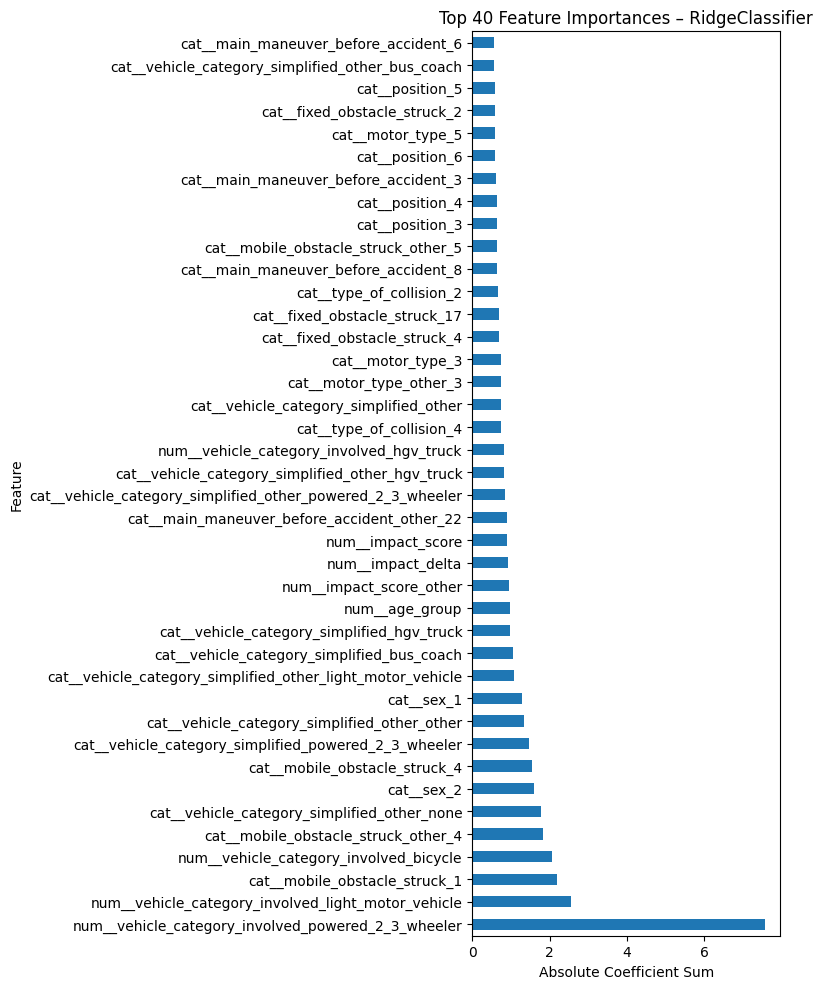

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

rf = pipeline_ridge_final.named_steps["classifier"]
pre = pipeline_ridge_final.named_steps["transform"]
feature_names = pre.get_feature_names_out()

# RidgeClassifier does not have feature_importances_. Using coef_ instead.
# Accessing the coef_ attribute for RidgeClassifier and ensuring it's in the correct shape
if hasattr(rf, 'coef_'):
    # For multiclass, coef_ can be (n_classes, n_features) or (n_features,)
    # Sum absolute coefficients across classes for overall importance if multiclass
    if rf.coef_.ndim > 1:
        importances = np.sum(np.abs(rf.coef_), axis=0)
    else:
        importances = np.abs(rf.coef_)
else:
    print("Classifier does not have 'coef_' attribute to determine importances.")
    importances = np.zeros(len(feature_names)) # Fallback to zeros if no coef_

forest_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(8, 10))
# Filter out zero importances before nlargest to avoid plotting non-informative features
non_zero_importances = forest_importances[forest_importances != 0]
if not non_zero_importances.empty:
    non_zero_importances.nlargest(40).plot(kind="barh")
    plt.title("Top 40 Feature Importances – RidgeClassifier")
    plt.xlabel("Absolute Coefficient Sum")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("No non-zero feature importances to plot.")

Calculating baseline (Most Frequent Class) performance...

--- Baseline (Most Frequent Class) Report ---
              precision    recall  f1-score   support

           0       0.47      1.00      0.64     51051
           1       0.00      0.00      0.00     39476
           2       0.00      0.00      0.00     17440

    accuracy                           0.47    107967
   macro avg       0.16      0.33      0.21    107967
weighted avg       0.22      0.47      0.30    107967

Baseline Weighted F1-Score: 0.3036
Baseline Weighted Cohen's Kappa: 0.0000
--------------------------------------------------

Evaluating model performance...

--- Model Classification Report ---
                  precision    recall  f1-score   support

       uninjured       0.83      0.74      0.78     51051
         injured       0.62      0.50      0.55     39476
severely injured       0.42      0.74      0.54     17440

        accuracy                           0.65    107967
       macro avg       0.6

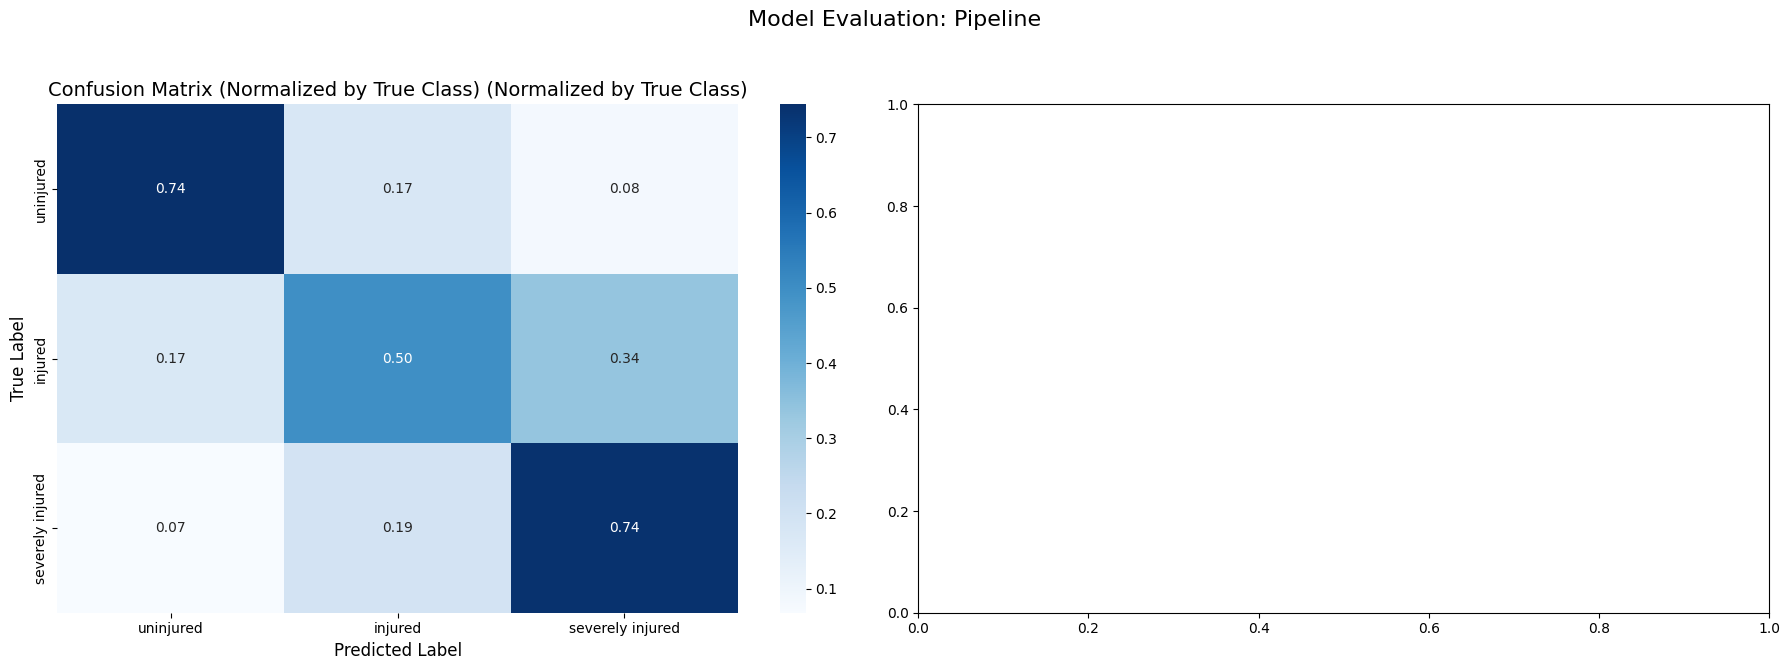

{'baseline_weighted_f1': 0.3035995907166489,
 'baseline_weighted_kappa': np.float64(0.0),
 'model_weighted_f1': 0.6586191619719923,
 'model_weighted_kappa': np.float64(0.6021152394327433)}

In [ ]:
from models.evaluation import run_classification_evaluation_non_prob


run_classification_evaluation_non_prob(pipeline_ridge_final, X_test, y_test, y_train, ["uninjured", "injured", "severely injured"],[0, 1, 2])

In [28]:
transformer_random_forest = ColumnTransformer([
    ('encoder', OrdinalEncoder(unknown_value=-1, handle_unknown='use_encoded_value'), ['vehicle_category_simplified', 'vehicle_category_simplified_other', 'role']),
    ('scaling', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline_balanced_random_forest = Pipeline(steps=[
    ('transformer', transformer_random_forest),
    ('classifier', BalancedRandomForestClassifier(
        verbose=0,
        n_jobs=5,
        ccp_alpha=1e-06,
        criterion='gini',
        max_depth=18,
        max_features='sqrt',
        min_samples_leaf=1,
        n_estimators=400,
        replacement=False,
        sampling_strategy='all'
    ))
])




In [29]:
pipeline_balanced_random_forest.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['vehicle_category_simplified',
                                                   'vehicle_category_simplified_other',
                                                   'role']),
                                                 ('scaling', MinMaxScaler(),
                                                  ['speed_limit',
                                                   'impact_score',
                                                   'impact_score_other',
                                                   'impact_delta',
                                                   'road_complexity...
                                                   'vehicle_category_involved_hgv_truck',
                                                   'vehicle_category_involved_light_motor_vehicle',
                                                   'vehicle_category_involved_other',
                                                   'vehicle_category_involved_powered_2_3_wheeler',
                                                   'weather_ordinal',
                                                   'lighting_ordinal',
                                                   'time_of_day',
                                                   'age_group'])])),
                ('classifier',
                 BalancedRandomForestClassifier(ccp_alpha=1e-06, max_depth=18,
                                                n_estimators=400, n_jobs=5,
                                                replacement=False))])

Calculating baseline (Most Frequent Class) performance...

--- Baseline (Most Frequent Class) Report ---
              precision    recall  f1-score   support

           0       0.47      1.00      0.64     51051
           1       0.00      0.00      0.00     39476
           2       0.00      0.00      0.00     17440

    accuracy                           0.47    107967
   macro avg       0.16      0.33      0.21    107967
weighted avg       0.22      0.47      0.30    107967

Baseline Weighted F1-Score: 0.3036
Baseline Weighted Cohen's Kappa: 0.0000
--------------------------------------------------

Evaluating model performance...

--- Model Classification Report ---
                  precision    recall  f1-score   support

       uninjured       0.87      0.73      0.80     51051
         injured       0.63      0.61      0.62     39476
severely injured       0.47      0.72      0.56     17440

        accuracy                           0.68    107967
       macro avg       0.6

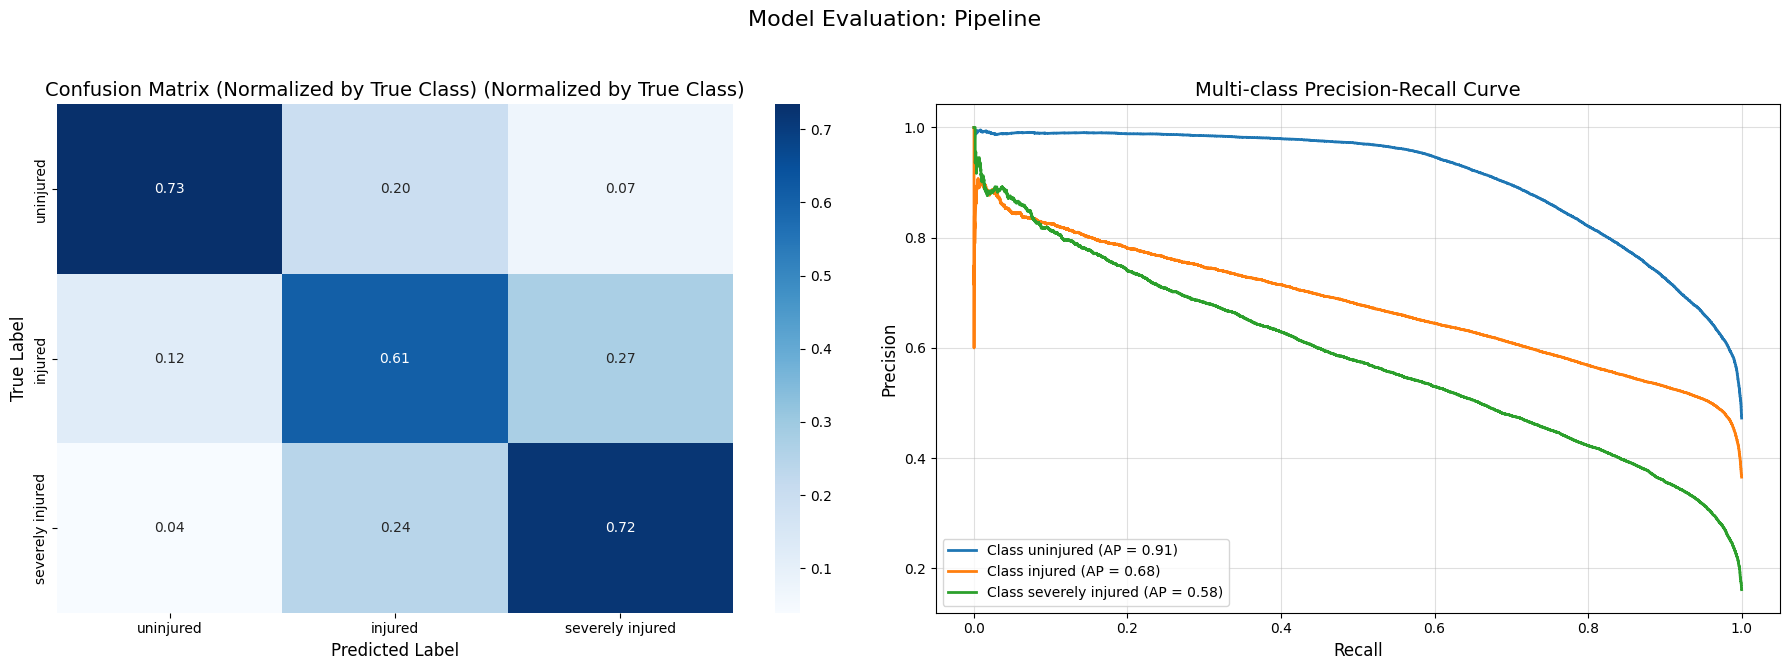

{'baseline_weighted_f1': 0.3035995907166489,
 'baseline_weighted_kappa': np.float64(0.0),
 'model_weighted_f1': 0.6937606489815019,
 'model_weighted_kappa': np.float64(0.6342705458021679)}

In [ ]:
from models.evaluation import run_classification_evaluation


run_classification_evaluation(pipeline_balanced_random_forest, X_test, y_test, y_train, ["uninjured", "injured", "severely injured"],[0, 1, 2])

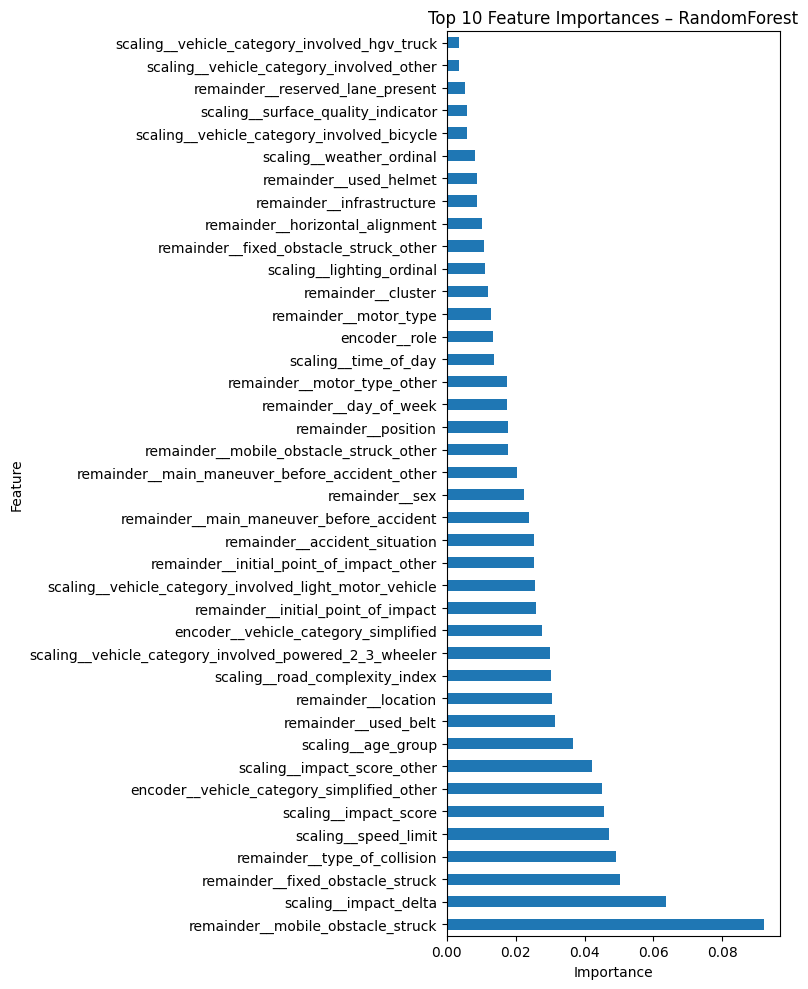

In [32]:

rf = pipeline_balanced_random_forest.named_steps["classifier"]
pre = pipeline_balanced_random_forest.named_steps["transformer"]
feature_names = pre.get_feature_names_out()

importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(8, 10))
forest_importances.nlargest(40).plot(kind="barh")
plt.title("Top 10 Feature Importances – RandomForest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [23]:
from catboost import CatBoostClassifier

categorical_cols_in_X_train = X_train.select_dtypes(include=['category']).columns.tolist()
cat_idx = [X_train.columns.get_loc(col) for col in categorical_cols_in_X_train]


In [24]:
classifier_cat = CatBoostClassifier(
    loss_function='MultiClassOneVsAll',
    eval_metric='TotalF1:average=Macro',  # macro F1
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced',
    cat_features=cat_idx,                 # fixed, not tuned
    random_seed=42,
    verbose=1,
    border_count=32,
    depth=10,
    iterations=5000,
    l2_leaf_reg=0.01,
    learning_rate=0.019411247872793094
)

In [26]:
classifier_cat.fit(X_train, y_train)


0:	learn: 0.5556200	total: 109ms	remaining: 9m 6s
1:	learn: 0.5547065	total: 251ms	remaining: 10m 27s
2:	learn: 0.5560501	total: 422ms	remaining: 11m 42s
3:	learn: 0.5557695	total: 556ms	remaining: 11m 34s
4:	learn: 0.5540329	total: 633ms	remaining: 10m 32s
5:	learn: 0.5552626	total: 689ms	remaining: 9m 33s
6:	learn: 0.5554870	total: 744ms	remaining: 8m 50s
7:	learn: 0.5554794	total: 811ms	remaining: 8m 26s
8:	learn: 0.5554921	total: 868ms	remaining: 8m 1s
9:	learn: 0.5557939	total: 925ms	remaining: 7m 41s
10:	learn: 0.5558185	total: 967ms	remaining: 7m 18s
11:	learn: 0.5559989	total: 1.01s	remaining: 7m
12:	learn: 0.5560366	total: 1.05s	remaining: 6m 44s
13:	learn: 0.5561268	total: 1.1s	remaining: 6m 30s
14:	learn: 0.5559186	total: 1.14s	remaining: 6m 19s
15:	learn: 0.5562583	total: 1.18s	remaining: 6m 8s
16:	learn: 0.5565200	total: 1.23s	remaining: 6m
17:	learn: 0.5578025	total: 1.27s	remaining: 5m 51s
18:	learn: 0.5587257	total: 1.31s	remaining: 5m 44s
19:	learn: 0.5711017	total: 1.

Calculating baseline (Most Frequent Class) performance...

--- Baseline (Most Frequent Class) Report ---
              precision    recall  f1-score   support

           0       0.47      1.00      0.64     51051
           1       0.00      0.00      0.00     39476
           2       0.00      0.00      0.00     17440

    accuracy                           0.47    107967
   macro avg       0.16      0.33      0.21    107967
weighted avg       0.22      0.47      0.30    107967

Baseline Weighted F1-Score: 0.3036
Baseline Weighted Cohen's Kappa: 0.0000
--------------------------------------------------

Evaluating model performance...

--- Model Classification Report ---
                  precision    recall  f1-score   support

       uninjured       0.85      0.77      0.81     51051
         injured       0.64      0.63      0.64     39476
severely injured       0.51      0.65      0.57     17440

        accuracy                           0.70    107967
       macro avg       0.6

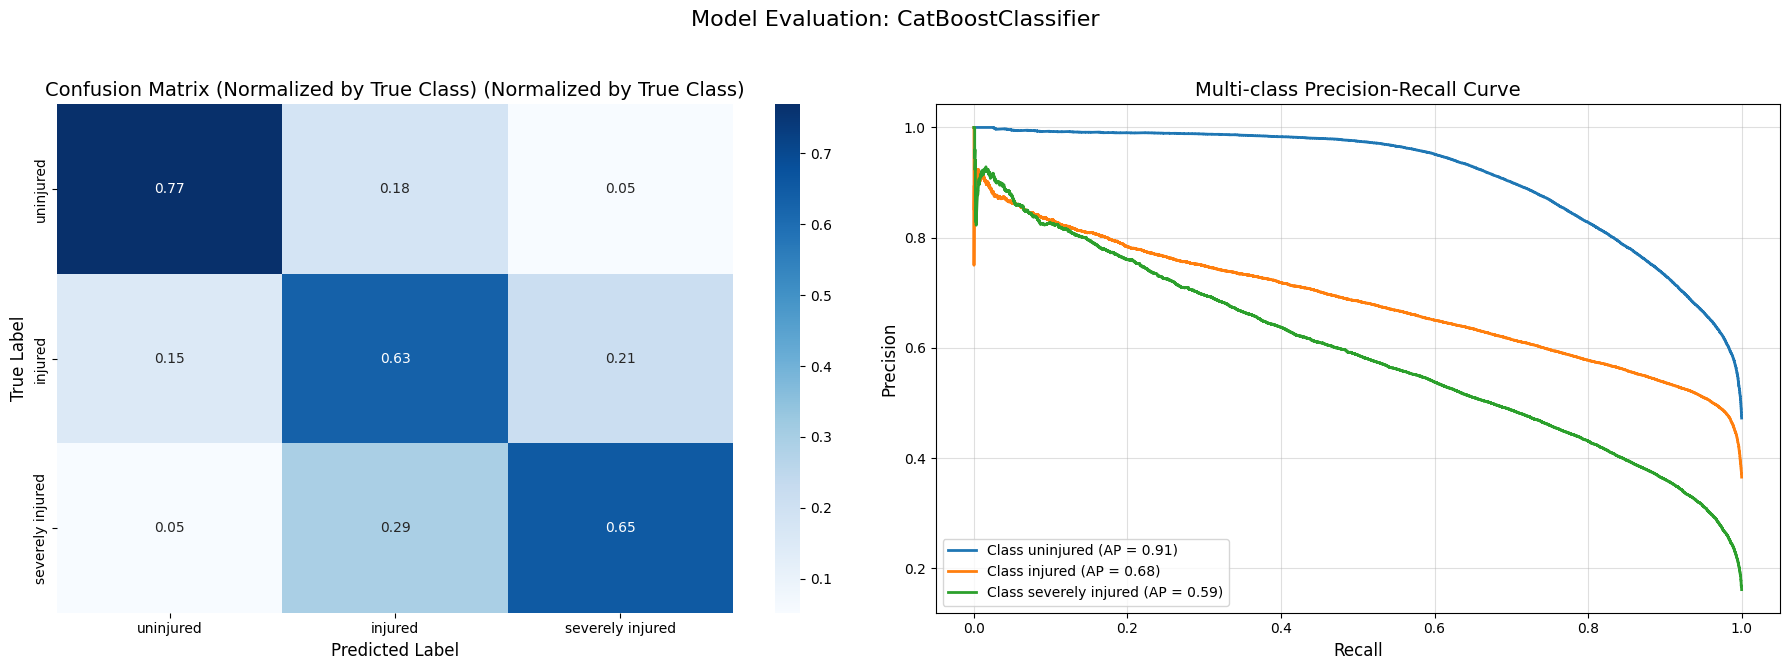

{'baseline_weighted_f1': 0.3035995907166489,
 'baseline_weighted_kappa': np.float64(0.0),
 'model_weighted_f1': 0.7067109038706821,
 'model_weighted_kappa': np.float64(0.6488330924231889)}

In [27]:
run_classification_evaluation(classifier_cat, X_test, y_test, y_train, ["uninjured", "injured", "severely injured"],[0, 1, 2])

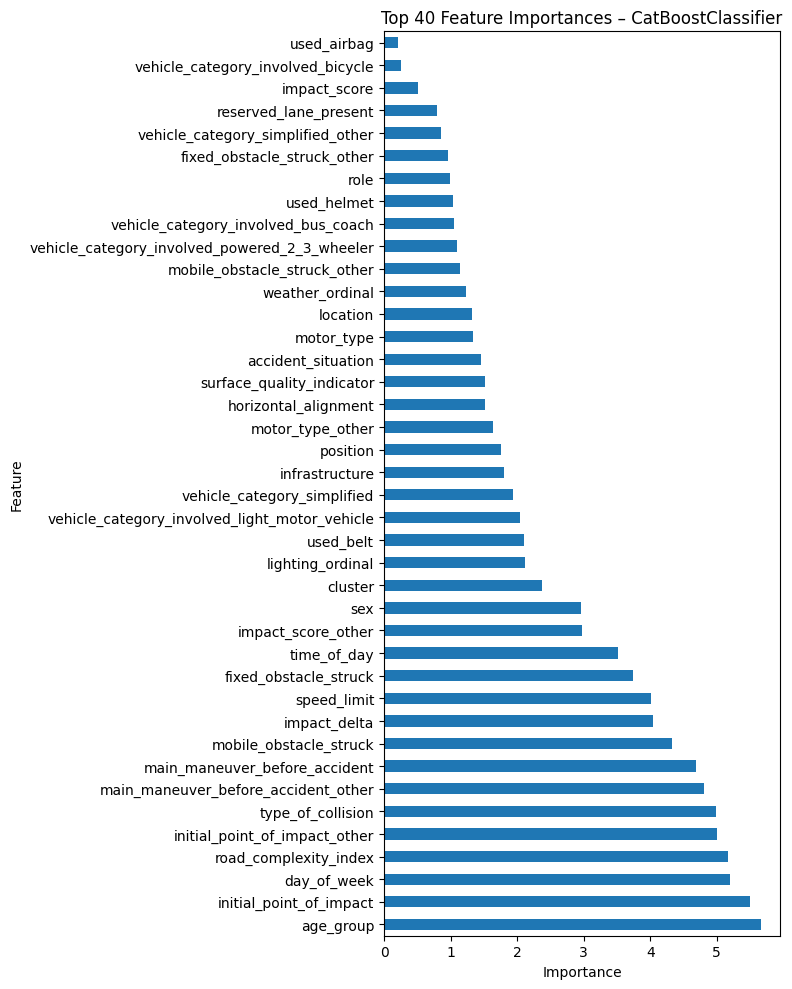

In [40]:
# Access the CatBoostClassifier directly, as it was not fitted within a pipeline
rf = classifier_cat
feature_names = X_train.columns # Get feature names from the original training data

# CatBoostClassifier uses get_feature_importance() method
importances = rf.get_feature_importance()
forest_importances = pd.Series(importances, index=feature_names)

plt.figure(figsize=(8, 10))
# Plot top 40 features for consistency and better visualization
forest_importances.nlargest(40).plot(kind="barh")
plt.title("Top 40 Feature Importances – CatBoostClassifier") # Updated title
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()